In [14]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
from torchinfo import summary
from torch.utils.data import DataLoader

from models.vae_trainer import VAETrainer

In [15]:
DATASET_PATH = os.path.join(os.getcwd(), 'data')

In [16]:
seed = 37
torch.manual_seed(seed)

In [17]:
class SensorDataset():
    def __init__(self, data: np.array):
        self.x = self.np2tensor(data)
        
    @staticmethod
    def np2tensor(x):
        return torch.tensor(x, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [18]:
latent_dims = 118
batch_size = 16
epochs = 1000

In [19]:
data_filename = 'data.mat'
data = loadmat(os.path.join(DATASET_PATH, data_filename))
Z = data['Z']
T = len(Z)
train_size = int(T * 0.8)
lr = 1e-1
scheduler = True
es_patience = 10

In [20]:
Z_train, Z_test = Z[:train_size], Z[train_size:]
training = SensorDataset(Z_train)
test = SensorDataset(Z_test)
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [21]:
trainer = VAETrainer(latent_dim=latent_dims, lr=lr, 
                     lr_scheduler=scheduler, es_patience=es_patience, seed=seed)

Device:  cpu


In [23]:
summary(trainer.vae, (1, 358))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 358]                  --
├─VariationalEncoder: 1-1                [1, 118]                  --
│    └─Linear: 2-1                       [1, 236]                  84,724
│    └─BatchNorm1d: 2-2                  [1, 236]                  472
│    └─Linear: 2-3                       [1, 118]                  27,966
│    └─Linear: 2-4                       [1, 118]                  14,042
│    └─Linear: 2-5                       [1, 118]                  14,042
├─Decoder: 1-2                           [1, 358]                  --
│    └─Linear: 2-6                       [1, 236]                  28,084
│    └─BatchNorm1d: 2-7                  [1, 236]                  472
│    └─Linear: 2-8                       [1, 358]                  84,846
Total params: 254,648
Trainable params: 254,648
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.25
Input size (MB): 

In [9]:
vae, mse, kl, val_mse, val_kl = trainer.train(train_dl, test_dl, epochs=epochs)

Epoch 1/1000: [MSE: 2.8472], [KL: 0.7205], [Val_MSE: 2.76], [Val_KL: 0.3466], 
Validation loss decreased (inf --> 2.763234).  Saving model ...
Epoch 2/1000: [MSE: 2.7719], [KL: 0.3466], [Val_MSE: 2.77], [Val_KL: 0.3466], 
EarlyStopping counter: 1 out of 10
Epoch 3/1000: [MSE: 2.7712], [KL: 0.3466], [Val_MSE: 2.76], [Val_KL: 0.3466], 
EarlyStopping counter: 2 out of 10
Epoch 4/1000: [MSE: 2.7698], [KL: 0.3467], [Val_MSE: 2.76], [Val_KL: 0.3466], 
Validation loss decreased (2.763234 --> 2.761361).  Saving model ...
Epoch 5/1000: [MSE: 2.7686], [KL: 0.3467], [Val_MSE: 2.76], [Val_KL: 0.3467], 
EarlyStopping counter: 1 out of 10
Epoch 6/1000: [MSE: 2.7690], [KL: 0.3467], [Val_MSE: 2.76], [Val_KL: 0.3466], 
EarlyStopping counter: 2 out of 10
Epoch 7/1000: [MSE: 2.7711], [KL: 0.3466], [Val_MSE: 2.76], [Val_KL: 0.3466], 
EarlyStopping counter: 3 out of 10
Epoch 8/1000: [MSE: 2.7680], [KL: 0.3467], [Val_MSE: 2.76], [Val_KL: 0.3466], 
EarlyStopping counter: 4 out of 10
Epoch 9/1000: [MSE: 2.768

In [10]:
def plot_learning(mse, kl, val_mse, val_kl):
    fig, axs = plt.subplots(2, figsize=(10,20))
    axs[0].plot(mse, color='r', label='Training')
    axs[0].plot(val_mse, color='b', label='Validation')
    axs[0].set_title('MSE Loss')
    axs[1].plot(kl, color='r', label='Training')
    axs[1].plot(val_kl, color='b', label='Validation')
    axs[1].set_title('KL Loss')
    plt.legend()
    #plt.savefig('./imgMix/mse-kl-mvae.pdf', format='pdf', dpi=1200)
    plt.show()

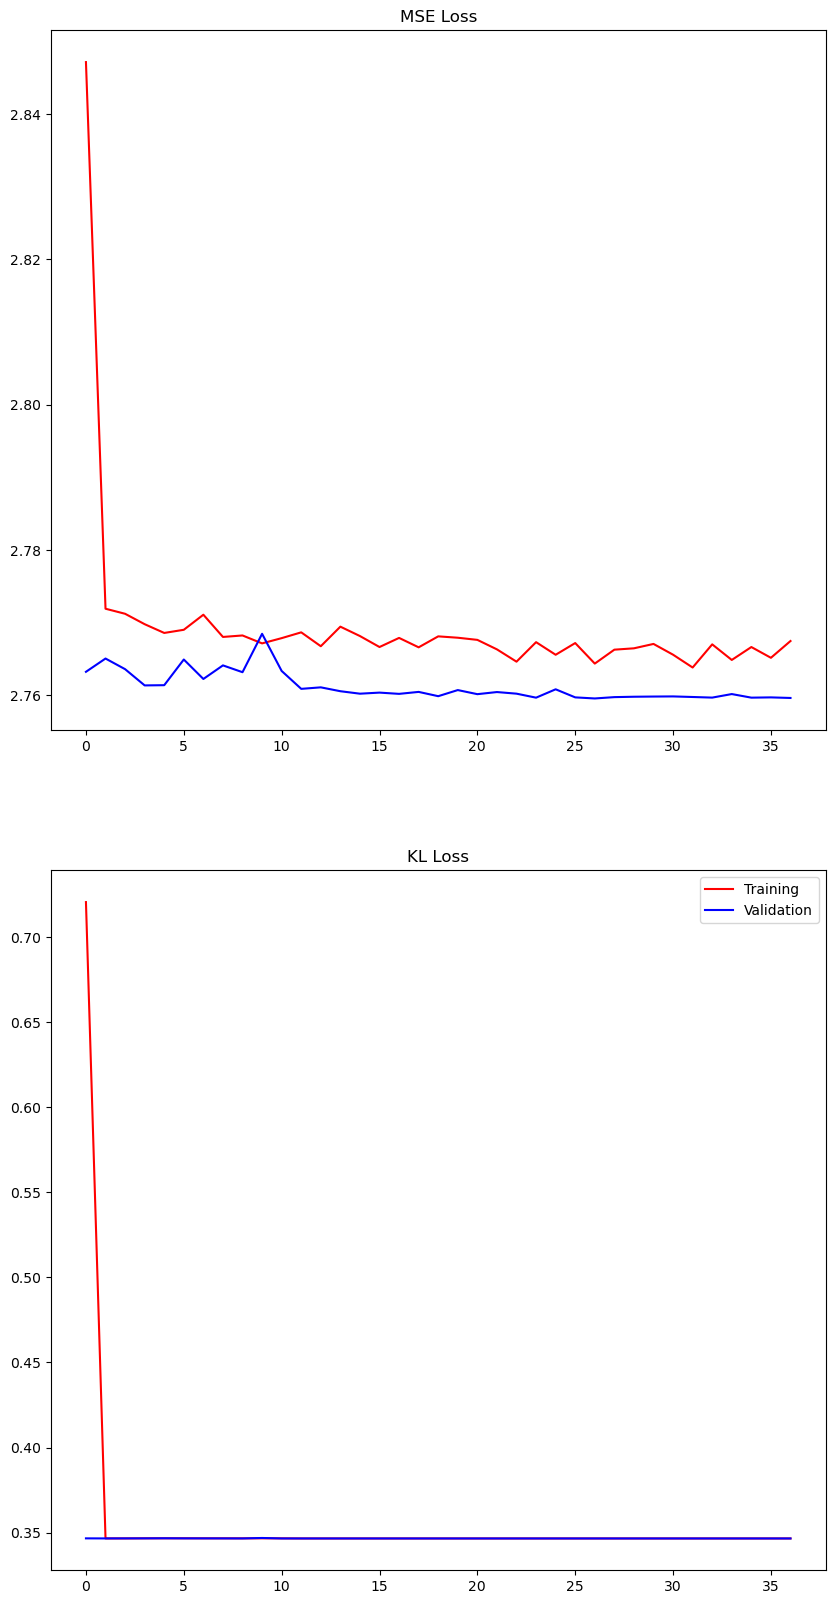

In [11]:
plot_learning(mse, kl, val_mse, val_kl)

In [12]:
vae.eval()
Z = torch.tensor(Z, dtype=torch.float32)
Z_enc = vae(Z)

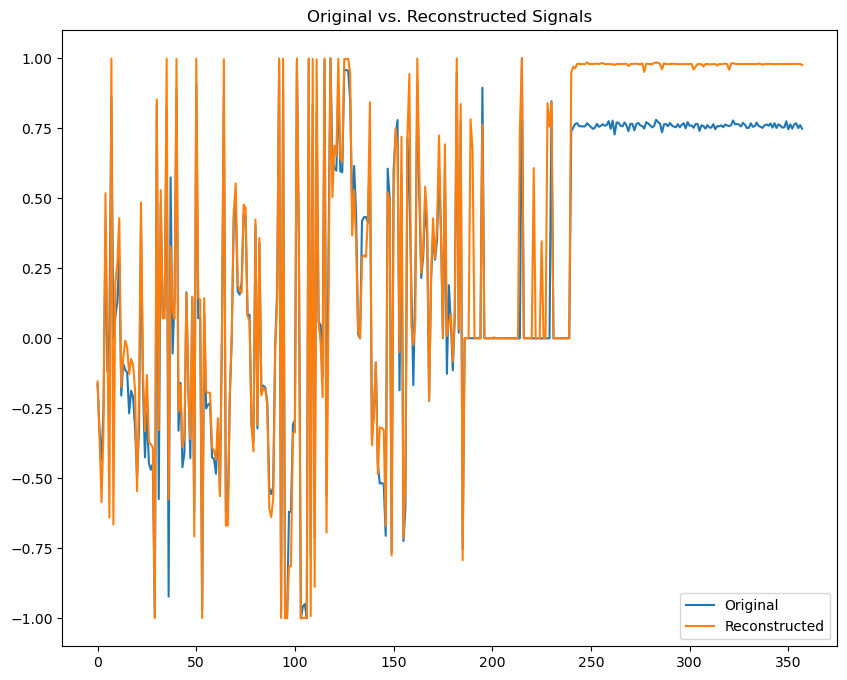

In [13]:
idx = 0
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(np.transpose(torch.tanh(Z[idx,:]).cpu().detach().numpy()), label='Original')
axs.plot(np.transpose(Z_enc[idx,:].cpu().detach().numpy()), label='Reconstructed')
axs.set_title('Original vs. Reconstructed Signals')
plt.legend()
plt.show()